![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
Segement customers based on RFM (Recency, Frequency, Monetary Valus) so that the company can target its customers efficiently.

### Steps:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

#### This kernel is based on the "Online Retail K-Means & Hierarchical Clustering" notebook

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [1]:
# import libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree

In [3]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# shape of df

retail.shape

(541909, 8)

In [5]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [8]:
# Find missing values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [9]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [11]:
# Changing the datatype of Customer Id 

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### Analyse customers based on RFM:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [32]:
# Create new attribute: "Monetary" for the total revenue contributed (Monetary)

retail['Monetary'] = retail['Quantity']*retail['UnitPrice']

rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [33]:
# Create new attribute: "Frequency" to count the number of transactions

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [34]:
# Merge the two DFs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [35]:
# Create new attribute: "Recency" to compute the number of days since the last purchase

# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

# Compute the last transaction date as the maximum date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [36]:
# Recency of every purchase: Difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,20.34


In [37]:
# Recency of a customer: last transaction date per customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [38]:
# get number of days
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [39]:
# again merge the DFs to get full RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### Outliers: can skew your dataset
Types:
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

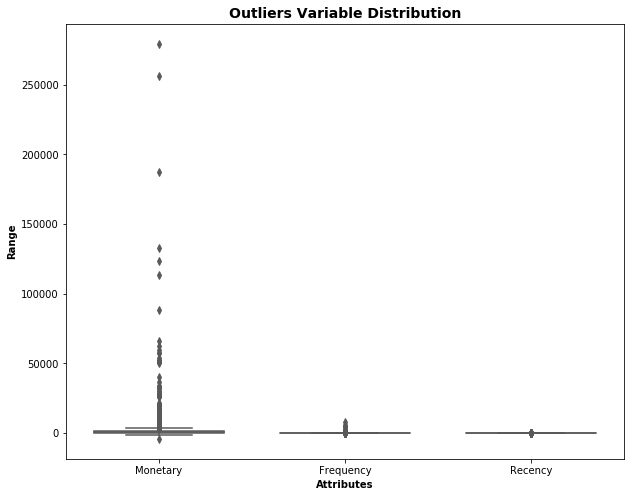

In [40]:
# Outlier analysis of Monetary Frequency and Recency

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [43]:
# Remove statistical outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05) # check parameters, play with these values
Q3 = rfm.Monetary.quantile(0.95)
CI = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*CI) & (rfm.Monetary <= Q3 + 1.5*CI)]

# Remove (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
CI = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*CI) & (rfm.Recency <= Q3 + 1.5*CI)]

# Remove (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
CI = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*CI) & (rfm.Frequency <= Q3 + 1.5*CI)]

### Rescaling Attributes

Rescale variables so that their scale is comparable.
Consider two ways of rescaling:

1. Min-Max scaling 
2. Whitening (mean-0, sigma-1) 

Example: Whitening. 
Implement Min-Max-scaling by analogy! 

In [52]:
# Rescaling attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_white = scaler.fit_transform(rfm_df)
rfm_df_white.shape

(4293, 3)

In [53]:
rfm_df_white = pd.DataFrame(rfm_df_scaled)
rfm_df_white.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_white.head()

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


<a id="4"></a> <br>
## Step 4 : Model

### Clustering with K-Means

In [54]:
# k-means with varying k (try different values)

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_white)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

### Find optimal number of clusters k

#### Measure for the number of clusters
* Elbow curve to get the right number of clusters

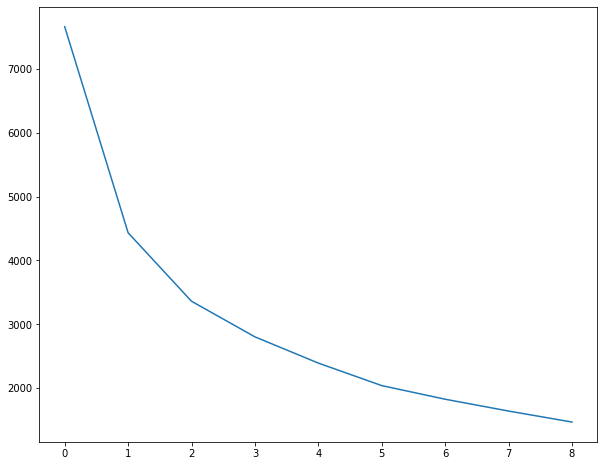

In [60]:
# Elbow-curve/SSD

ssd = []

range_n_clusters = [2, 3, 4, 5, 6, 7, 8 ,9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    silhouette_score(rfm_df_white,kmeans.labels_)
    
    ssd.append(kmeans.inertia_)

    
# plot the SSDs for each n_clusters
plt.plot(ssd)


### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ : mean distance to points in the nearest cluster that a considered data point is not a part of

$q$ : mean distance to all the points in the cluster of the considered point

* The silhouette score ranges between -1 to 1. (1 indicates good clustering, -1 indicates poor clustering)

In [62]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_white)
    cluster_labels = kmeans.labels_
    
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_white, cluster_labels)
    print("For #_clusters={0}, silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For #_clusters=2, silhouette score is 0.5415858652525395
For #_clusters=3, silhouette score is 0.5084896296141937
For #_clusters=4, silhouette score is 0.4814786837400834
For #_clusters=5, silhouette score is 0.466103965297297
For #_clusters=6, silhouette score is 0.41771162187117405
For #_clusters=7, silhouette score is 0.4177054772702703
For #_clusters=8, silhouette score is 0.4006798277751833
For #_clusters=9, silhouette score is 0.4141268269895099
For #_clusters=10, silhouette score is 0.379833631191043


In [63]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_white)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [64]:
 kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

In [65]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


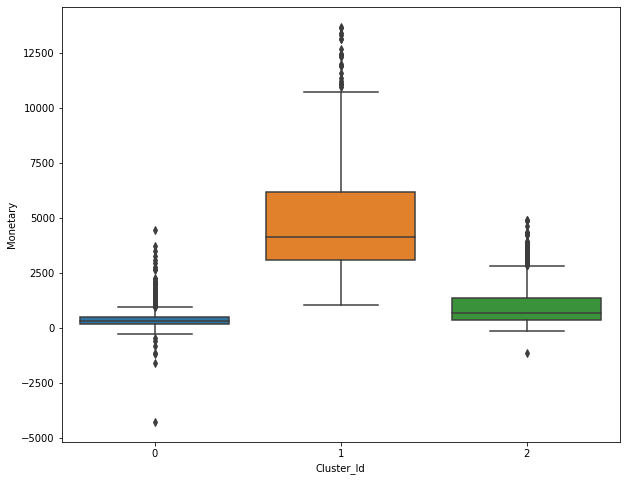

In [67]:
# Box plot to visualize Cluster Id vs Monetary

sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

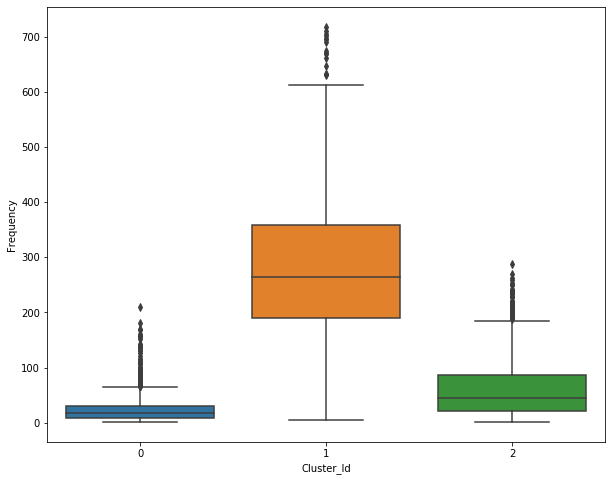

In [68]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

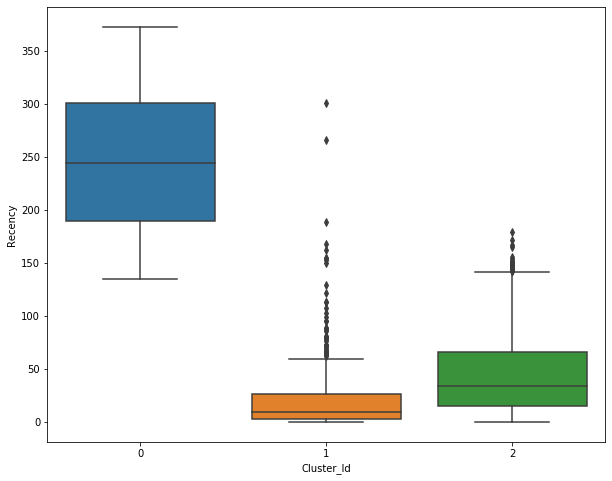

In [69]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<a id="5"></a> <br>
## Step 5 : Final Analysis

### Inference:
K-Means clustering with 3 clusters
- Customers with Cluster Id 1 are the customers with high amount of transactions compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers.